In [4]:
from configs import CFG1
from generators import create_image
from generation_utils import split_sentence

In [5]:
import pandas as pd

messages = pd.read_csv("texts/message_samples.csv")
names = pd.read_csv("texts/name_samples.csv")
messages.shape, names.shape

((14, 5), (10, 5))

'<ruby>血統書<rt>けっとうしょ</rt></ruby>付きの<ruby>子牛<rt>こうし</rt></ruby>は、<ruby>王家<rt>おうけ</rt></ruby>の<ruby>宝<rt>たから</rt></ruby>だからね。大事にされるんだよ?ねっ!?いいかぁ!'

'<ruby>後川 寅吉<rt>そのかわ とらきち</rt></ruby>'

'<ruby>天真<rt>てんしん</rt></ruby>らんまんを装っておられるところを見ると、そのつもりはないようではありますが'

'それにしてもこの<ruby>台形<rt>だいけい</rt></ruby>のお<ruby>皿<rt>さら</rt></ruby>に盛り付けるのに<ruby>一苦労<rt>いちくろう</rt></ruby>ですねえ。'

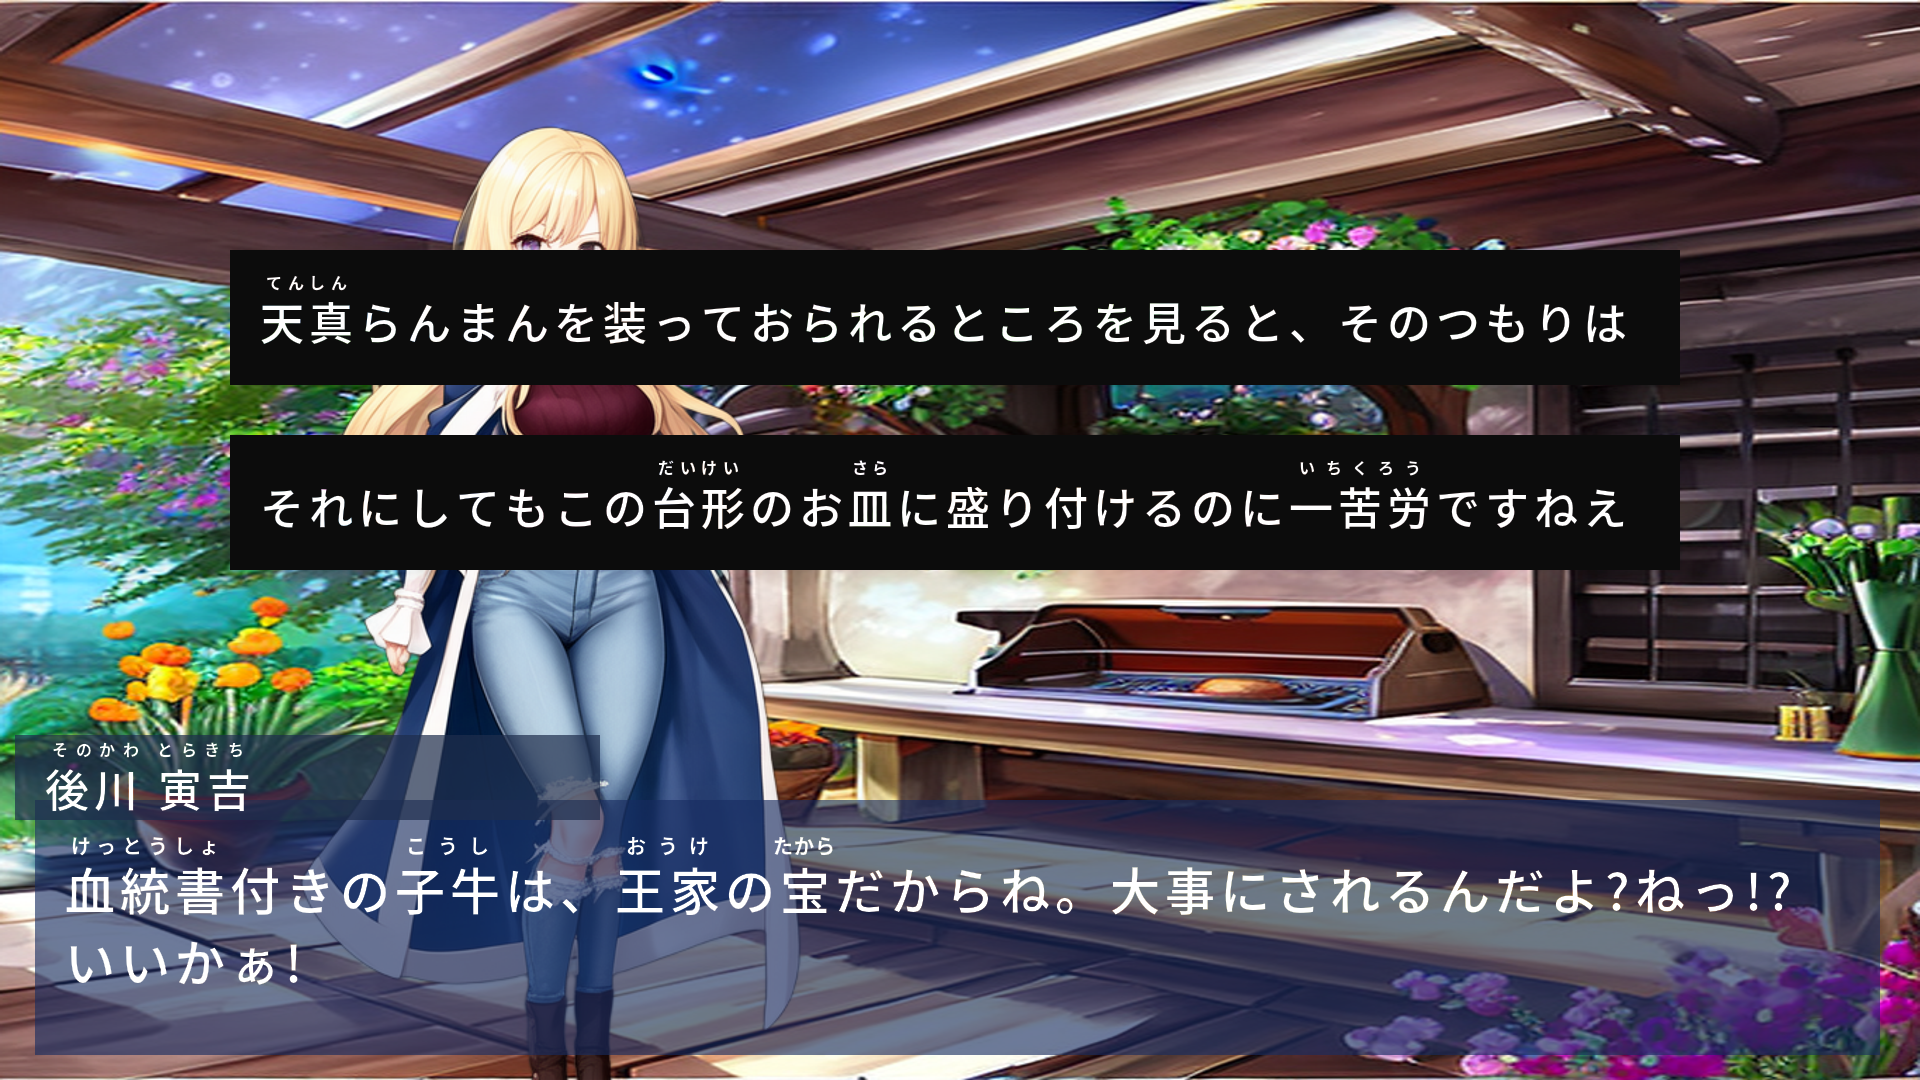

In [7]:
cfg = CFG1()

text = messages.sample(1)["text_ruby_hiragana"].values[0]
cfg.text = text

name_text = names.sample(1)["text_ruby_hiragana"].values[0]
cfg.name_text = name_text

option_text = split_sentence(messages.sample(1)["text_ruby_hiragana"].values[0])[0]
option2_text = split_sentence(messages.sample(1)["text_ruby_hiragana"].values[0])[-1]
cfg.option_texts = [option_text, option2_text]

output = create_image(cfg)

display(text, name_text, option_text, option2_text)
display(output.image)

In [8]:
output.text, output.name_text, output.option_texts

('<ruby>血統書<rt>けっとうしょ</rt></ruby>付きの<ruby>子牛<rt>こうし</rt></ruby>は、<ruby>王家<rt>おうけ</rt></ruby>の<ruby>宝<rt>たから</rt></ruby>だからね。大事にされるんだよ?ねっ!?いいかぁ!',
 '<ruby>後川 寅吉<rt>そのかわ とらきち</rt></ruby>',
 ['<ruby>天真<rt>てんしん</rt></ruby>らんまんを装っておられるところを見ると、そのつもりは',
  'それにしてもこの<ruby>台形<rt>だいけい</rt></ruby>のお<ruby>皿<rt>さら</rt></ruby>に盛り付けるのに<ruby>一苦労<rt>いちくろう</rt></ruby>ですねえ'])